# **Fear Conditioning Neural and Behavioral Responses in Syngap1+/Delta-GAP Rats: LFP, EEG, and Accelerometer Data**

This tutorial shows how to access and process data from [DANDI:001457](https://dandiarchive.org/dandiset/001457/draft) using pynwb.

## Study Overview

The experiment investigated fear conditioning in male wild-type and Syngap+/Delta-GAP rats (n=31, ages 3-6 months). Recordings included Local Field Potentials (LFP), electroencephalogram (EEG), head-mounted accelerometer data, and behavioral video recordings across five experimental days. The protocol involved context habituation, seizure screening, and a fear conditioning paradigm where rats were exposed to blue flashing light (5 Hz, 110 lux) paired with foot shocks. Data were collected using OpenEphys software and a 16-channel Intan digitizing head stage. Behavioral paradigm triggers were managed using FreezeFrame software, and behavioral cameras recorded rat movements throughout the experimental sessions. The experimental design allowed for assessing neural responses, seizure occurrence, and fear learning in these genetic variants.

## Contents

1. [Setup and Data Access](#setup)
2. [Session and Subject Metadata](#metadata)
3. [EEG Data and Metadata](#eeg)
4. [LFP Data and Metadata](#lfp)
5. [Behavioral Video and Metadata](#video)
6. [Accelerometer Data](#accelerometer)
7. [Behavioural Paradigm Triggers](#ttls)

---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [27]:
# Core data manipulation and analysis
from pathlib import Path

import h5py

# Visualization
import matplotlib.pyplot as plt
import remfile
from dandi.dandiapi import DandiAPIClient

# NWB and DANDI access
from pynwb import NWBHDF5IO

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Data Access Functions

In [28]:
def load_nwb_from_dandi(dandiset_id, subject_id, session_id):
    """
    Load NWB file from DANDI Archive via streaming.
    """
    pattern = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}*.nwb"
    
    with DandiAPIClient() as client:
        client.dandi_authenticate()
        assets = client.get_dandiset(dandiset_id, "draft").get_assets_by_glob(
            pattern=pattern, order="path"
        )
        
        s3_urls = []
        for asset in assets:
            s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
            s3_urls.append(s3_url)
        
        if len(s3_urls) != 1:
            raise ValueError(f"Expected 1 file, found {len(s3_urls)} for pattern {pattern}")
        
        s3_url = s3_urls[0]
    
    file = remfile.File(s3_url)
    h5_file = h5py.File(file, "r")
    io = NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io


def load_nwb_local(directory_path, subject_id, session_id):
    """
    Load NWB file from local directory.
    """
    directory_path = Path(directory_path)
    nwbfile_path = directory_path / f"sub-{subject_id}_ses-{session_id}.nwb"
    
    if not nwbfile_path.exists():
        raise FileNotFoundError(f"NWB file not found: {nwbfile_path}")
    
    io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io

In [29]:
# Load session data
dandiset_id = "001457"
subject_id = "Rat-1021"  # Example subject
session_id = "Recall"  # Start with first session type

# Choose data source (DANDI streaming or local)
USE_DANDI = True  # Set to False to use local files

if USE_DANDI:
    nwbfile, io = load_nwb_from_dandi(dandiset_id, subject_id, session_id)
else:
    # Specify your local directory path
    local_directory = "YOUR_DIRECTORY_PATH"  # Replace with actual path
    nwbfile, io = load_nwb_local(local_directory, subject_id, session_id)

c:\Users\amtra\anaconda3\envs\kind-lab-to-nwb-env\Lib\site-packages\hdmf\spec\namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


---

# 2. Session and Subject Metadata <a id="metadata"></a>

In [30]:
print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile.experiment_description}")
print(f"Session description:\n {nwbfile.session_description}")
print(f"Session start time:\n {nwbfile.session_start_time}")

=== SESSION INFORMATION ===
Experiment description:
 The experiment investigated fear conditioning in male wild-type and Syngap1+/Delta-GAP rats (n=31, ages 3-6 months). Recordings included Local Field Potentials (LFP), electroencephalogram (EEG), head-mounted accelerometer data, and behavioral video recordings across five experimental days. The protocol involved context habituation, seizure screening, and a fear conditioning paradigm where rats were exposed to blue flashing light (5 Hz, 110 lux) paired with foot shocks. Data were collected using OpenEphys software and a 16-channel Intan digitizing head stage. Behavioral paradigm triggers were managed using FreezeFrame software, and behavioral cameras recorded rat movements throughout the experimental sessions. The experimental design allowed for assessing neural responses, seizure occurrence, and fear learning in these genetic variants.
Session description:
 Experimental day 5. Fear response assessment session with re-exposure to the 

In [31]:
print("=== SUBJECT INFORMATION ===")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Age: {nwbfile.subject.age}")
print(f"Strain: {nwbfile.subject.species}")
print(f"Genotype: {nwbfile.subject.genotype}")
print(f"Sex: {nwbfile.subject.sex}")

=== SUBJECT INFORMATION ===
ID: Rat_1021
Age: P12W/P24W
Strain: Rattus norvegicus
Genotype: WT
Sex: M


---

# 3. EEG Data and Metadata <a id="eeg"></a>

This section demonstrates how to access the EEG data.

`NWB` organizes data into different groups depending on the type of data. Groups can be thought of as folders within the file. Here are some of the groups within an NWBFile and the types of data they are intended to store:

- `acquisition`: raw, acquired data that should never change
- `processing`: processed data, typically the results of preprocessing algorithms and could change

## EEG signals 

The EEG data is stored in [pynwb.ecephys.ElectricalSeries](https://pynwb.readthedocs.io/en/stable/pynwb.ecephys.html#pynwb.ecephys.ElectricalSeries) object, which are added to `nwbfile.acquisition`.

The data in ElectricalSeries is stored as a two-dimensional array:

The first dimension corresponds to time (individual samples).
The second dimension corresponds to recorded channels.
Each row in the array represents a single time point, and each column corresponds to the signal recorded from a specific channel.

In [32]:
print("=== ACQUISITION MODULE ===\n")
for name, acq in nwbfile.acquisition.items():
    print(f"{name}")
    if "eeg_series" in name:
        eeg_series_name = name

=== ACQUISITION MODULE ===

Video rat_1021_recall
bad_channels_series
eeg_series


In [33]:
# Access eeg data
eeg_series = nwbfile.acquisition[eeg_series_name]

print("=== EEG SIGNAL ===")
print(f"Name: {eeg_series.name}")
print(f"Data shape: {eeg_series.data.shape}")
print(f"Sampling rate: {eeg_series.rate} Hz")
print(f"Duration: {eeg_series.data.shape[0] / eeg_series.rate:.2f} seconds")

=== EEG SIGNAL ===
Name: eeg_series
Data shape: (2268160, 3)
Sampling rate: 2000.0 Hz
Duration: 1134.08 seconds


## Electrode Metadata

In [34]:
print("=== ELECTRODE METADATA ===")
print("All electrode metadata are stored in the electrode dynamic table and reference in the series:")
eeg_series.electrodes.to_dataframe()

=== ELECTRODE METADATA ===
All electrode metadata are stored in the electrode dynamic table and reference in the series:


,location,group,group_name,channel_name,probe_shank,probe_electrode,bad_channel,ref_elect_id
id,,,,,,,,
9,OB,OB_EEG_electrode_group abc.NwbElectrodeGroup a...,OB_EEG_electrode_group,CH10,9,9,False,9
10,M1,M1_EEG_electrode_group abc.NwbElectrodeGroup a...,M1_EEG_electrode_group,CH11,10,10,False,10
11,HPC,HPC_EEG_electrode_group abc.NwbElectrodeGroup ...,HPC_EEG_electrode_group,CH12,11,11,False,11


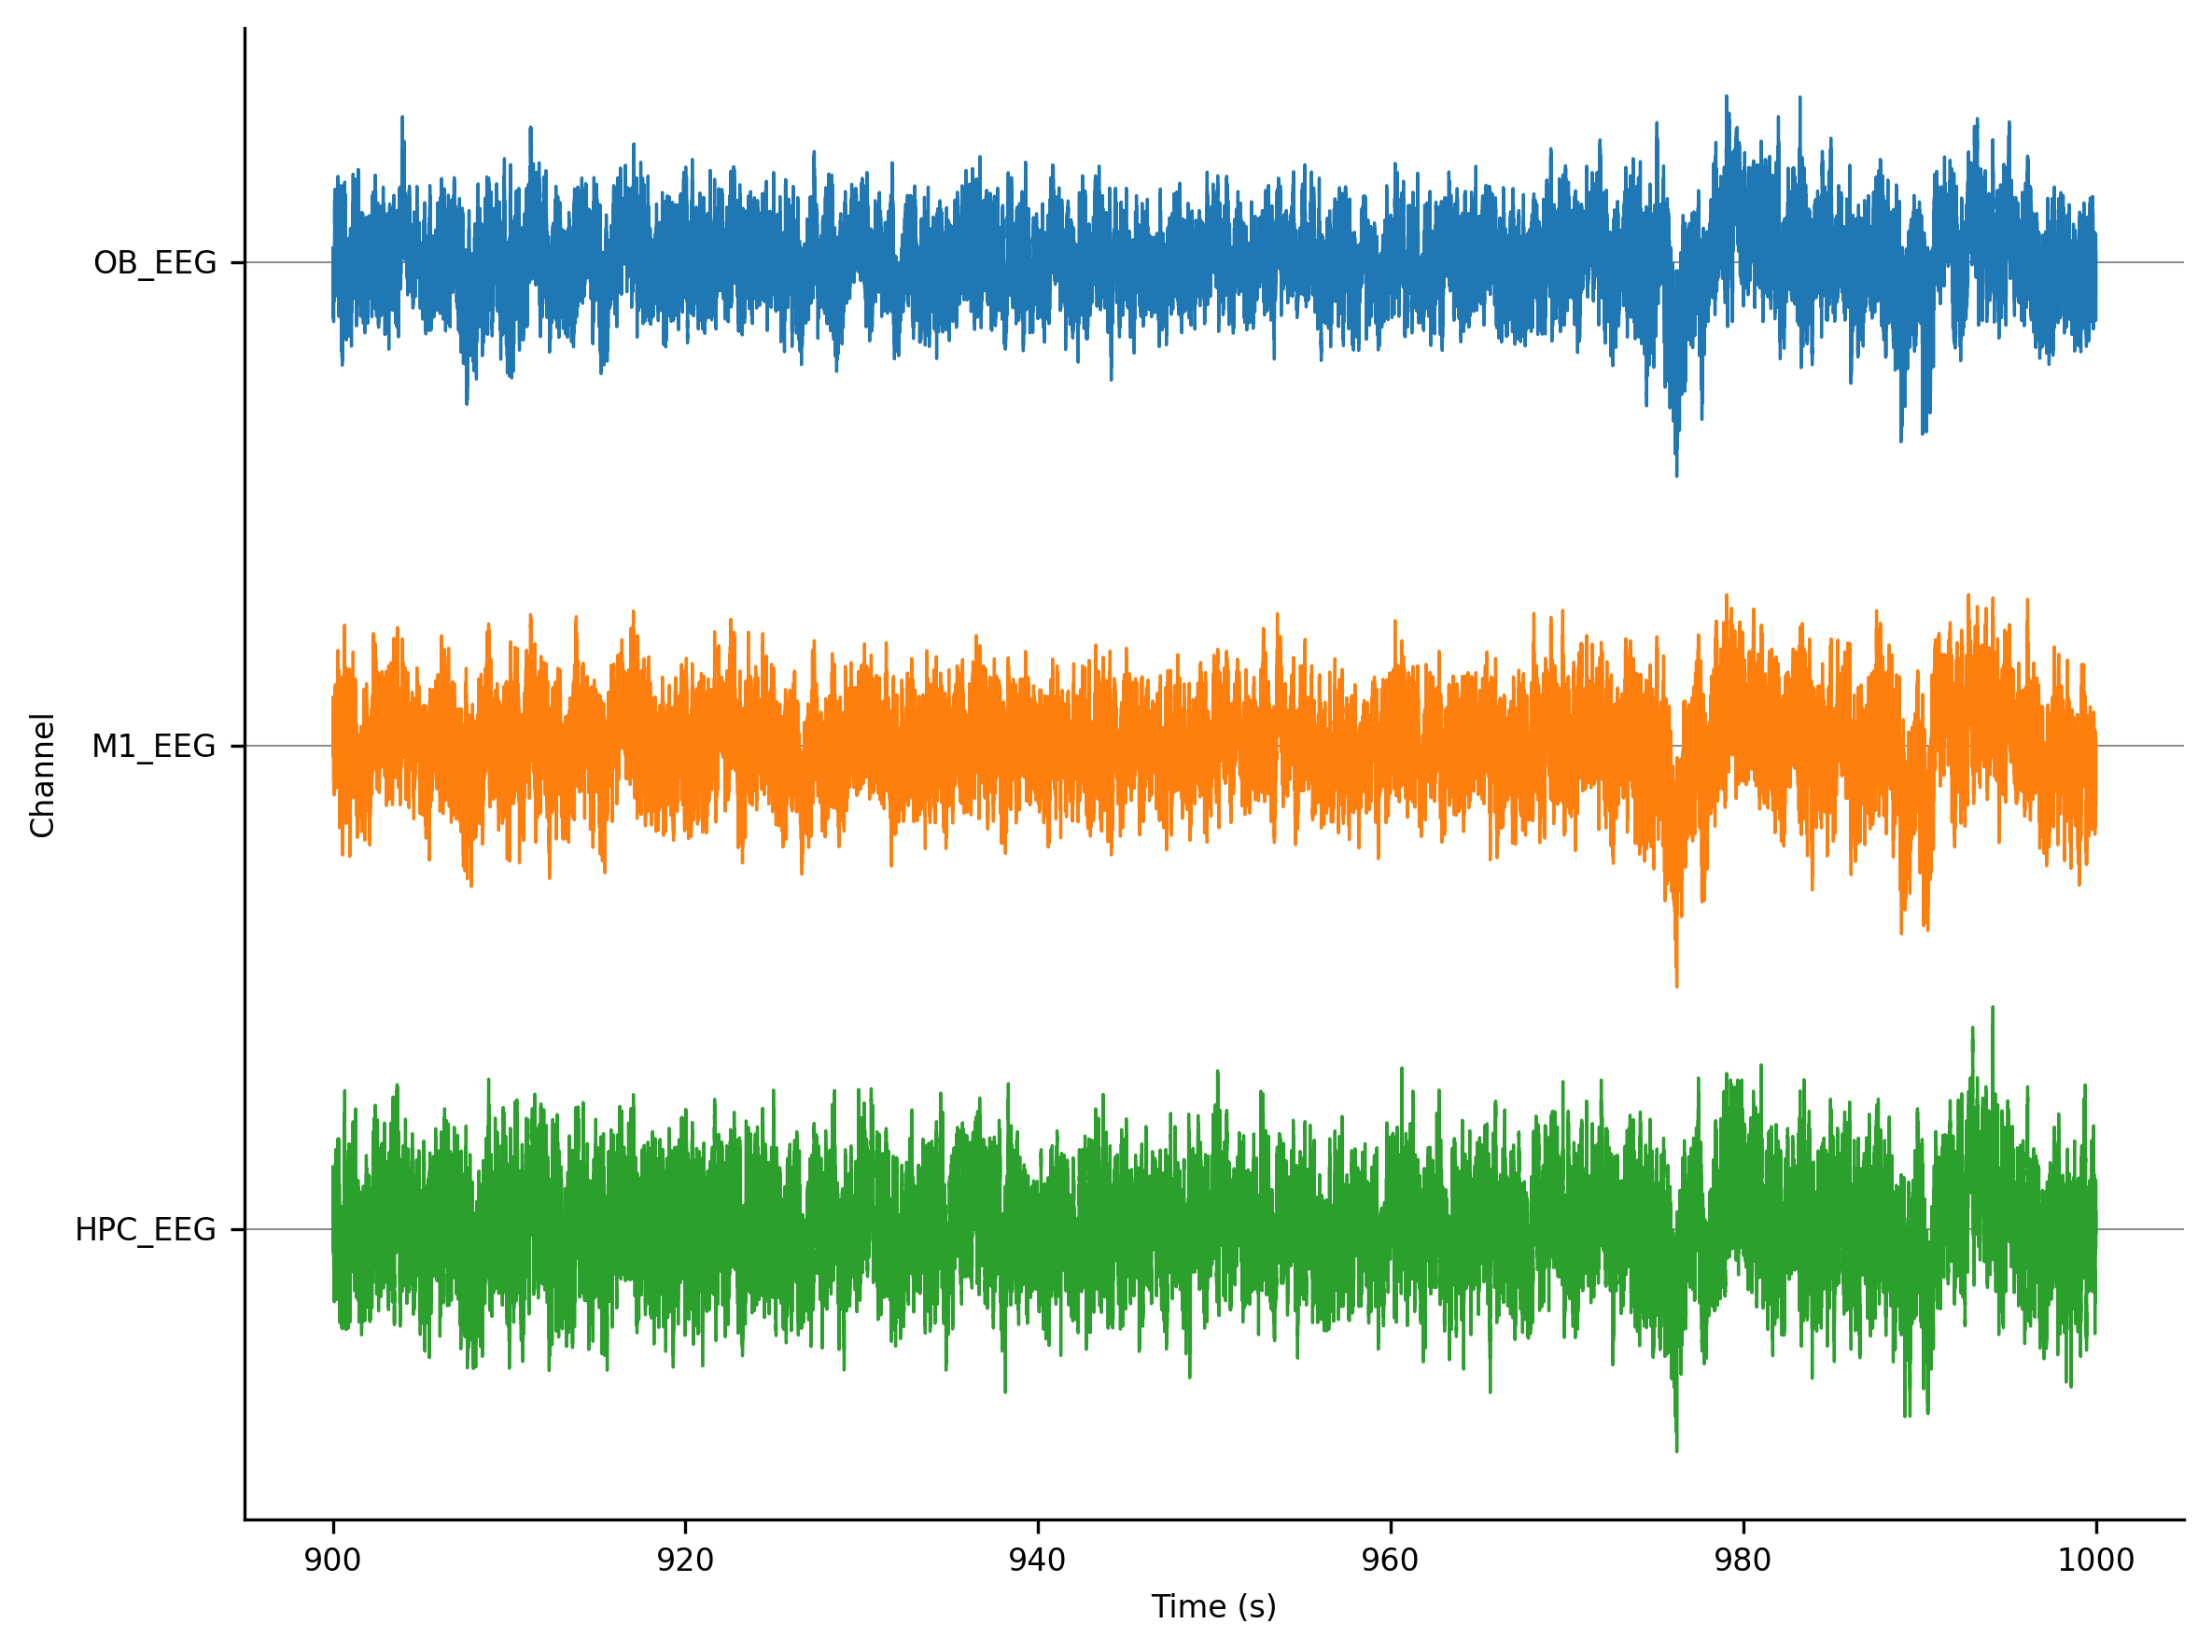

In [35]:
import numpy as np
from matplotlib import pyplot as plt

# Define your window (start and end indices)
start_time = 900  # seconds
end_time = 1000.0  # seconds
timestamps = eeg_series.get_timestamps()
start_idx = np.where(timestamps >= start_time)[0][0] if len(np.where(timestamps >= start_time)[0]) > 0 else 0
end_idx = (
    np.where(timestamps <= end_time)[0][-1] if len(np.where(timestamps <= end_time)[0]) > 0 else len(timestamps) - 1
)

# Get the data and timestamps properly
data = np.array(eeg_series.data[start_idx:end_idx])
timestamps = timestamps[start_idx:end_idx]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Calculate offset for stacking
offset = float(np.max(np.abs(data)) * 2)
y_positions = []

# Plot zero lines for each channel
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.9, linewidth=0.5)
    y_positions.append(y_offset)

# Plot the LFP signals with offset
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.plot(timestamps, data[:, i] + y_offset, linewidth=0.8)

# # Add scale bar
# scale_x = timestamps[0] + (timestamps[-1] - timestamps[0]) * 0.05  # 5% from left
# scale_y = max(y_positions) + offset/2
# ax.plot([scale_x, scale_x], [scale_y, scale_y + 1000], 'k-', linewidth=2)
# ax.text(scale_x + 0.01, scale_y + 500, '1000 µV', rotation=90, va='center')

# Style the plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.tick_params(axis="both", labelsize=8)
ax.set_yticks(y_positions)
yticklabels = eeg_series.electrodes.to_dataframe()["group_name"]
yticklabels = yticklabels.str.replace("_electrode_group", "")
ax.set_yticklabels(yticklabels, fontsize=8)

plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("Channel", fontsize=8)

plt.tight_layout()
plt.show()

---

# 4. LFP Data and Metadata <a id="lfp"></a>

This section demonstrates how to access the LFP data.

## LFP signals 

LFP data are stored in a [pynwb.ecephys.ElectricalSeries](https://pynwb.readthedocs.io/en/stable/pynwb.ecephys.html#pynwb.ecephys.ElectricalSeries) object. To help data analysis and visualization tools know that this ElectricalSeries object represents LFP data, the ElectricalSeries object is stored inside of an LFP object.

In [36]:
print("=== PROCESSING MODULE ===\n")
for name, proc in nwbfile.processing.items():
    print(f"{name}")
    for name, lfp in proc.data_interfaces.items():
            print(f"\t{name}")

=== PROCESSING MODULE ===

behavior
	analog
	behavioral_events
ecephys
	LFP
tasks
	task_table


In [37]:
# Access eeg data
lfp_series = nwbfile.processing["ecephys"]["LFP"].electrical_series["lfp_series"]

print("=== LFP SIGNAL ===")
print(f"Name: {lfp_series.name}")
print(f"Data shape: {lfp_series.data.shape}")
print(f"Sampling rate: {lfp_series.rate} Hz")
print(f"Duration: {lfp_series.data.shape[0] / lfp_series.rate:.2f} seconds")

=== LFP SIGNAL ===
Name: lfp_series
Data shape: (2268160, 7)
Sampling rate: 2000.0 Hz
Duration: 1134.08 seconds


## Electrode Metadata

In [38]:
print("=== LFP ELECTRODE METADATA ===")
print("All electrode metadata are stored in the electrode dynamic table and reference in the series:")
lfp_series.electrodes.to_dataframe()

=== LFP ELECTRODE METADATA ===
All electrode metadata are stored in the electrode dynamic table and reference in the series:


,location,group,group_name,channel_name,probe_shank,probe_electrode,bad_channel,ref_elect_id
id,,,,,,,,
0,V1,V1_LFP_electrode_group abc.NwbElectrodeGroup a...,V1_LFP_electrode_group,CH1,0,0,False,0
2,Aud,Aud_LFP_electrode_group abc.NwbElectrodeGroup ...,Aud_LFP_electrode_group,CH3,2,2,False,2
3,Aud,Aud_LFP_electrode_group abc.NwbElectrodeGroup ...,Aud_LFP_electrode_group,CH4,3,3,False,3
5,mPFC,mPFC_LFP_electrode_group abc.NwbElectrodeGroup...,mPFC_LFP_electrode_group,CH6,5,5,False,5
6,mPFC,mPFC_LFP_electrode_group abc.NwbElectrodeGroup...,mPFC_LFP_electrode_group,CH7,6,6,False,6
8,LA,LA_LFP_electrode_group abc.NwbElectrodeGroup a...,LA_LFP_electrode_group,CH9,8,8,False,8
12,Crus I,CrusI_LFP_electrode_group abc.NwbElectrodeGrou...,CrusI_LFP_electrode_group,CH13,12,12,False,12


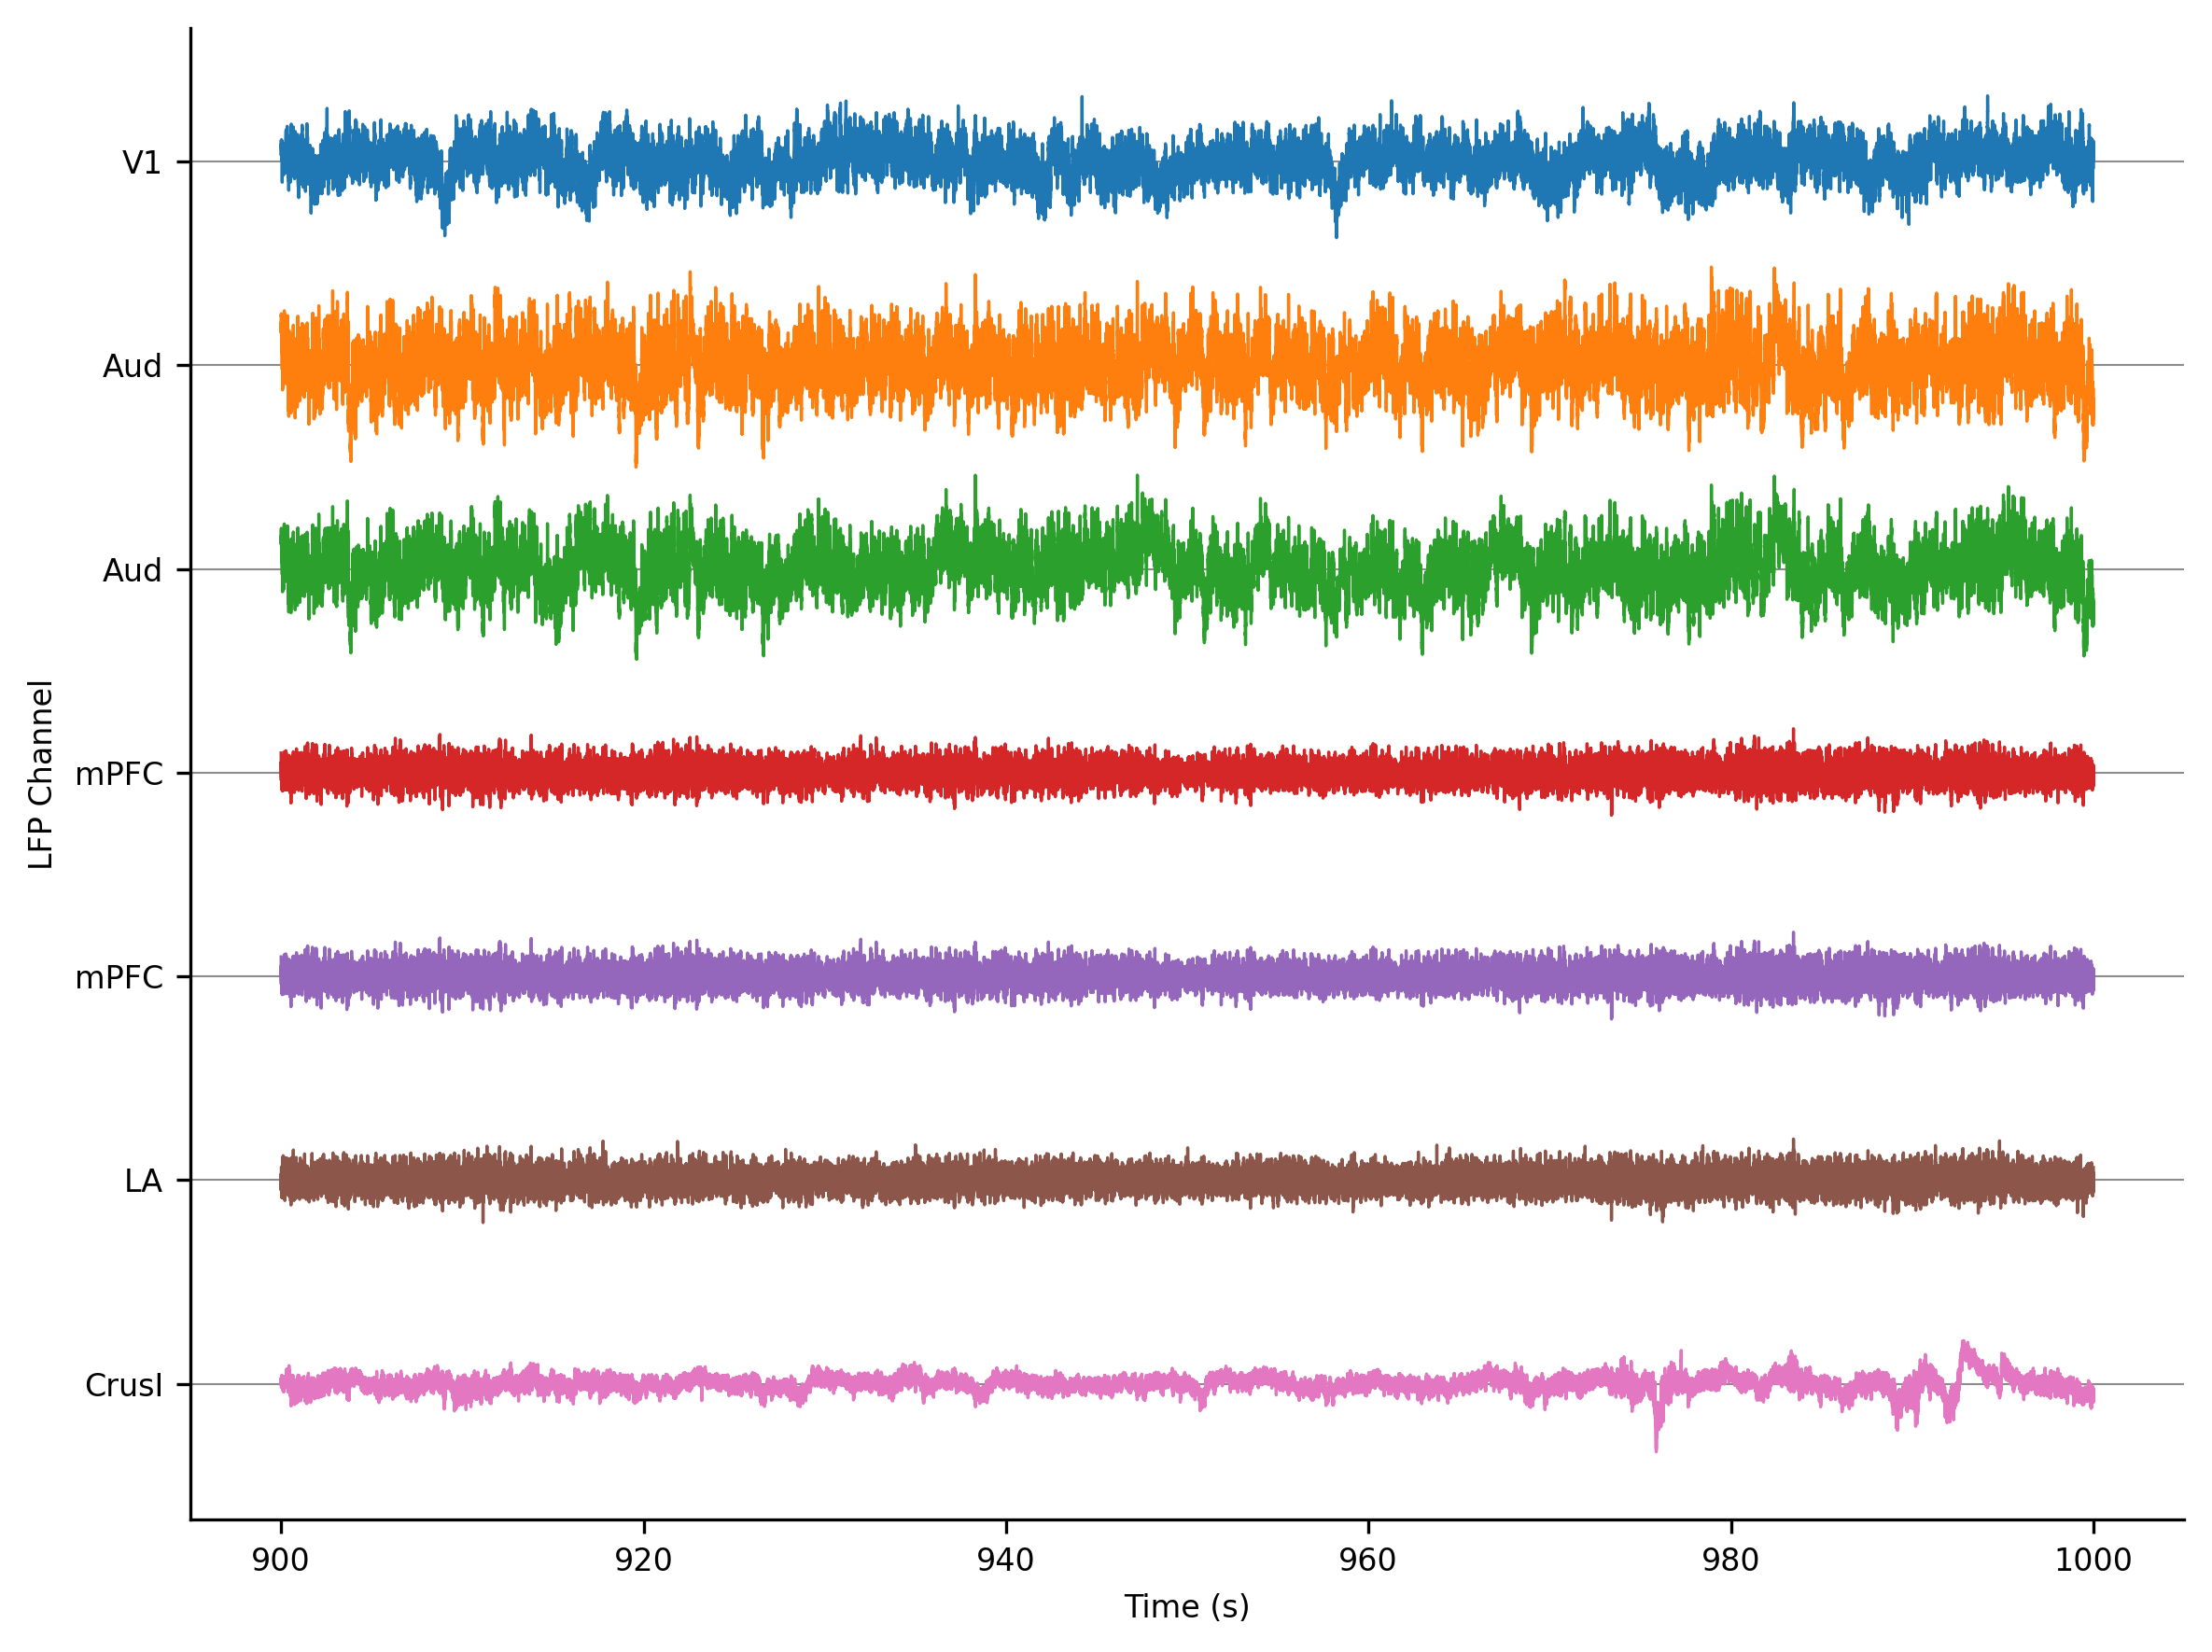

In [39]:
import numpy as np
from matplotlib import pyplot as plt

# Define your window (start and end indices)
start_time = 900  # seconds
end_time = 1000.0  # seconds
timestamps = lfp_series.get_timestamps()
start_idx = np.where(timestamps >= start_time)[0][0] if len(np.where(timestamps >= start_time)[0]) > 0 else 0
end_idx = (
    np.where(timestamps <= end_time)[0][-1] if len(np.where(timestamps <= end_time)[0]) > 0 else len(timestamps) - 1
)

# Get the data and timestamps properly
data = np.array(lfp_series.data[start_idx:end_idx])
timestamps = timestamps[start_idx:end_idx]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Calculate offset for stacking
offset = float(np.max(np.abs(data)) * 2)
y_positions = []

# Plot zero lines for each channel
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.9, linewidth=0.5)
    y_positions.append(y_offset)

# Plot the LFP signals with offset
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.plot(timestamps, data[:, i] + y_offset, linewidth=0.8)

# # Add scale bar
# scale_x = timestamps[0] + (timestamps[-1] - timestamps[0]) * 0.05  # 5% from left
# scale_y = max(y_positions) + offset/2
# ax.plot([scale_x, scale_x], [scale_y, scale_y + 1000], 'k-', linewidth=2)
# ax.text(scale_x + 0.01, scale_y + 500, '1000 µV', rotation=90, va='center')

# Style the plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.tick_params(axis="both", labelsize=8)
ax.set_yticks(y_positions)
yticklabels = lfp_series.electrodes.to_dataframe()["group_name"]
yticklabels = yticklabels.str.replace("_LFP_electrode_group", "")
ax.set_yticklabels(yticklabels, fontsize=8)

plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("LFP Channel", fontsize=8)

plt.tight_layout()
plt.show()

---

# 5. Behavioral Video <a id="ogen"></a>
NB: not all sessions have behavioral video data

In [40]:
# Access behavioral video information
video_name = None
for name, acq in nwbfile.acquisition.items():
    if "Video" in name:
        video_name = name

if video_name is not None:
    video = nwbfile.acquisition[video_name]
    print("=== BEHAVIORAL VIDEO ===")
    print(f"Video file path: {video.external_file[0]}")
else:
    print("No behavioral video found in this session.")

=== BEHAVIORAL VIDEO ===
Video file path: sub-Rat-1021_ses-Recall_behavior+ecephys+image\d91e13f0-7c31-4ecd-8fbf-9e49519a7602_external_file_0.avi


The metadata data of the device used to record the behavioral video:

In [41]:
video.device  # Display video device information

camera_device 0 abc.CameraDevice at 0x2548096054800
Fields:
  camera_name: fear_conditioning_camera
  description: Camera used to record the behavior of the animals during the experiments.
  lens: Carl Zeiss lens with 20-step autofocus
  manufacturer: Logitech
  meters_per_pixel: 0.0004
  model: C920

---

# 6. Accelerometer Signal <a id="accelerometer"></a>

This section demonstrates how to access the accelerometer signals recorded during the experiment. The accelerometer data need to be stored in the `processing` module under `behavior/analog` for compatibility reason with the SensorData table ingested by the Spyglass pipeline.

The accelerometer data can be accessed using `nwbfile.processing["behavior"]["analog"]["analog"]` which returns an TimeSeries object containing the acceleration measurements along different axes (the order need to be explicit in the description of the series).

In [42]:
accelerometer_series = nwbfile.processing["behavior"]["analog"]["analog"]
accelerometer_series

Data type,int16
Shape,"(2268160, 3)"
Array size,12.98 MiB
Chunk shape,None
Compression,None
Compression opts,None
Uncompressed size (bytes),13608960
Compressed size (bytes),13608960
Compression ratio,1.0


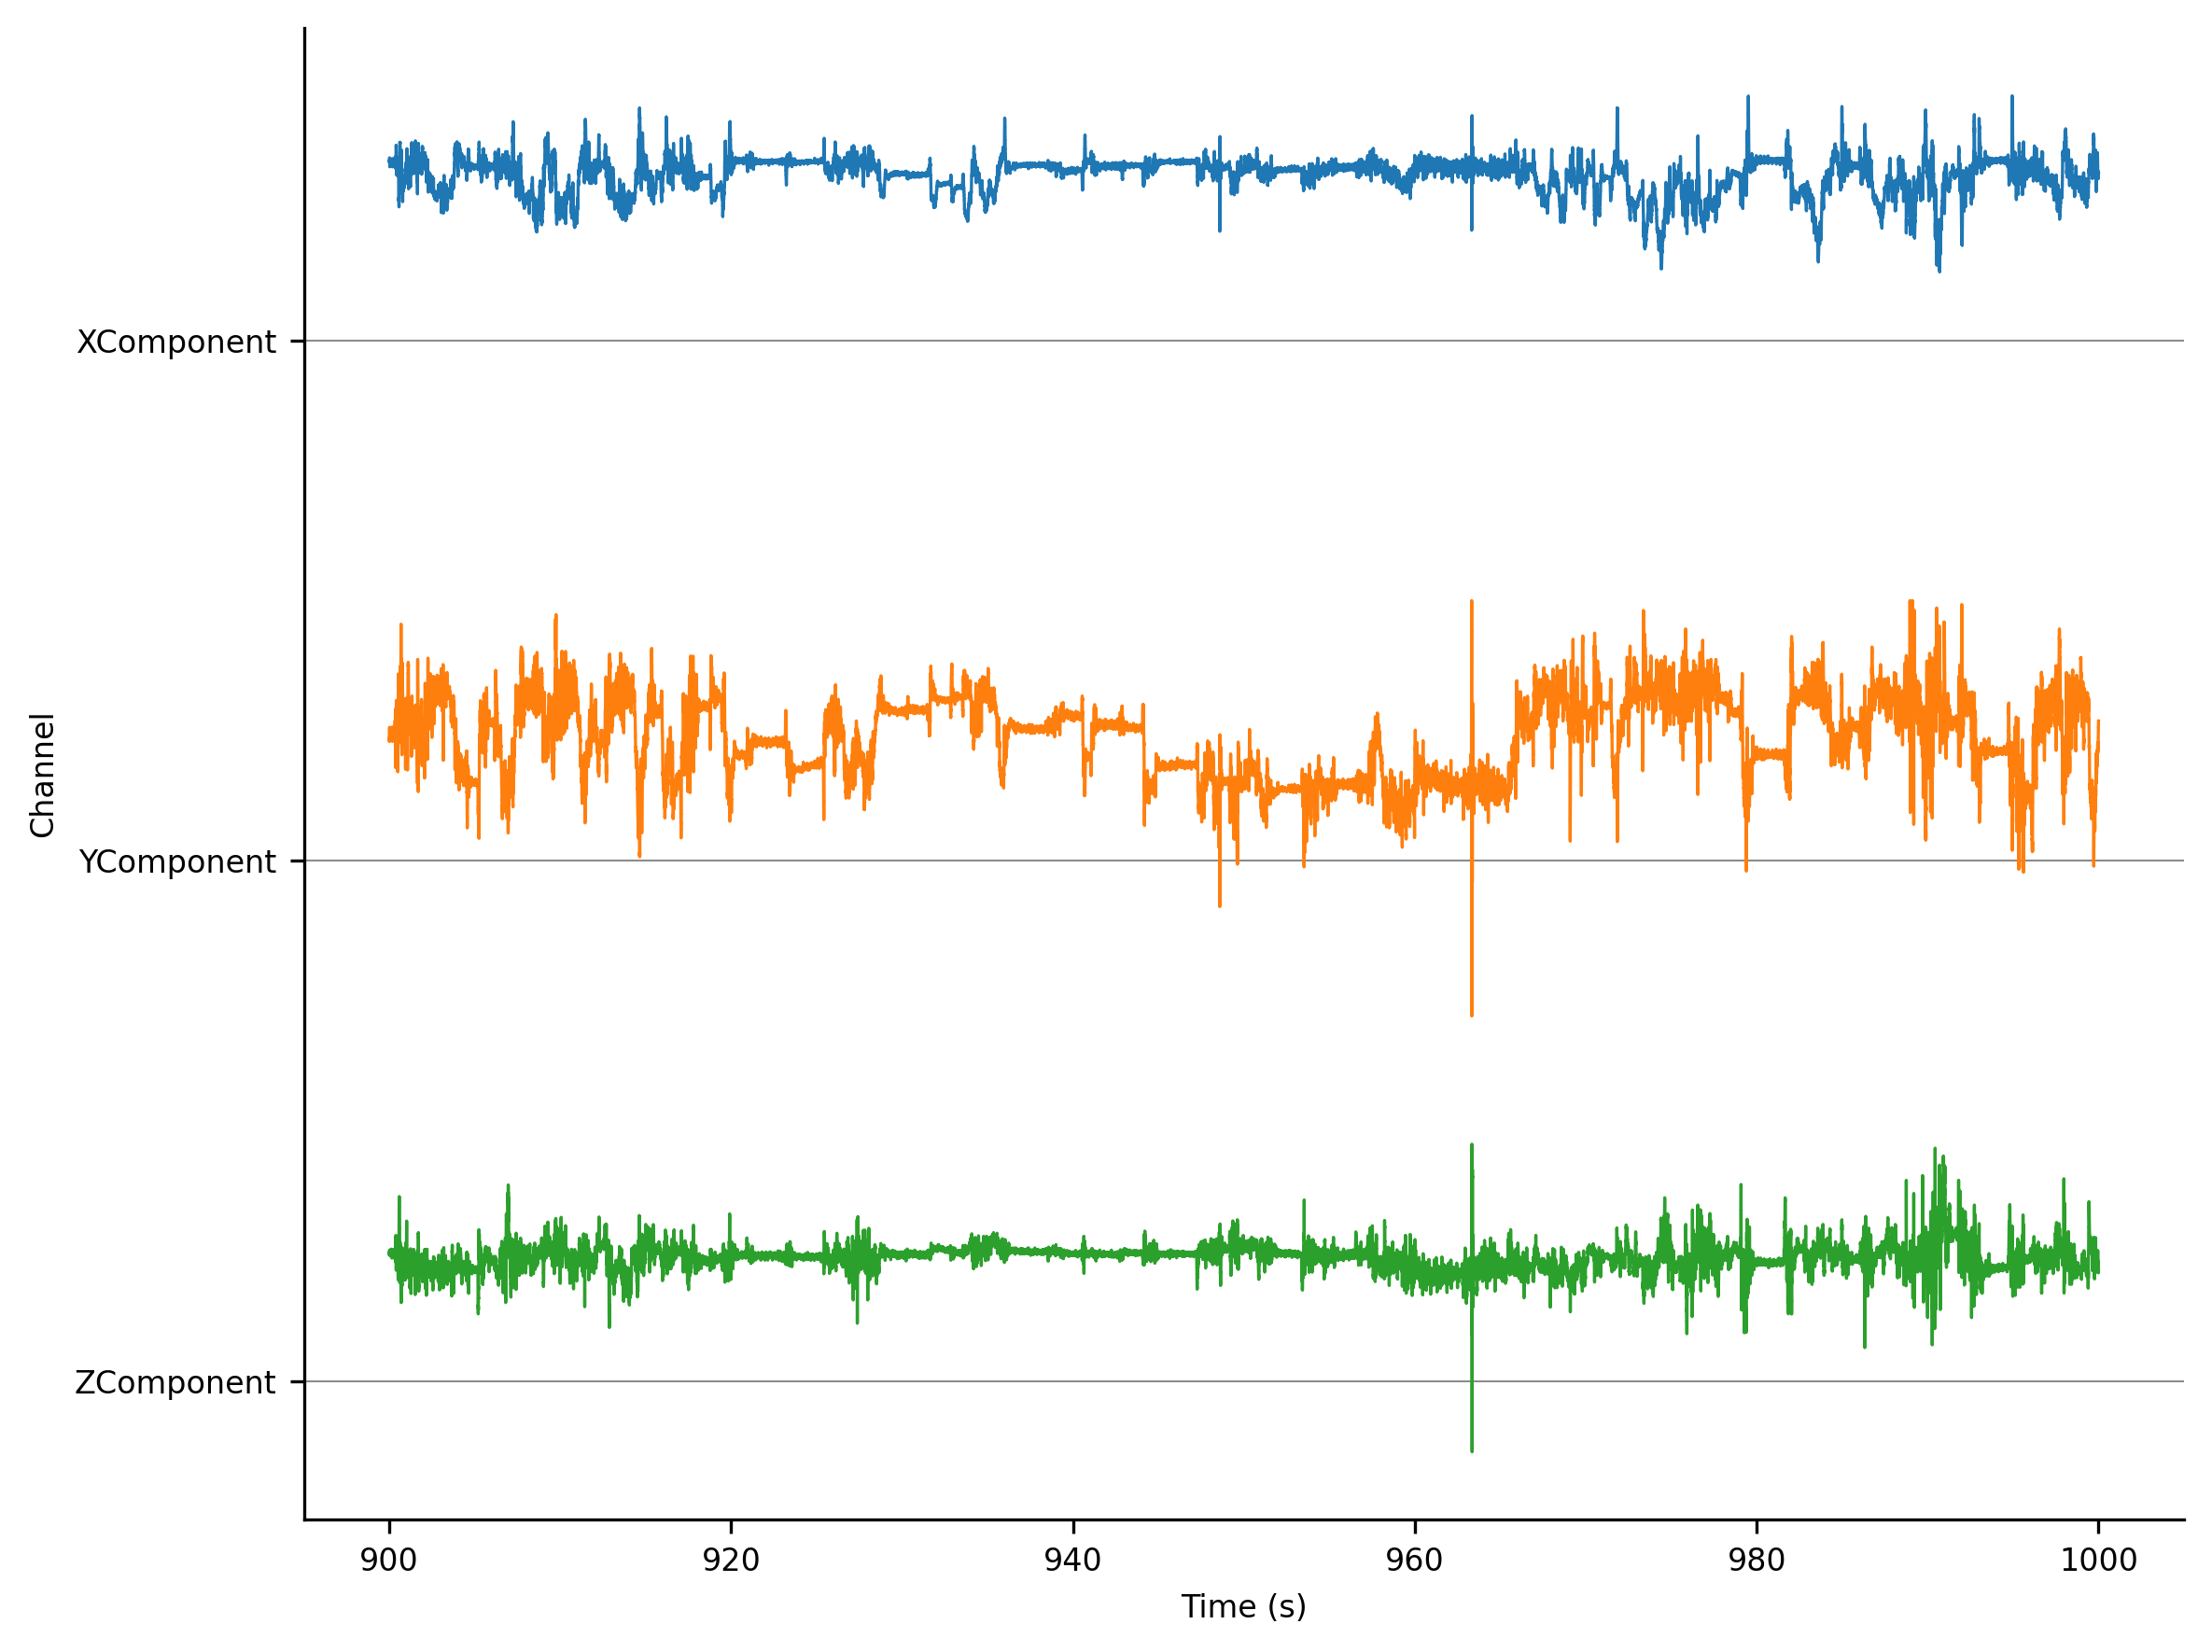

In [43]:
import numpy as np
from matplotlib import pyplot as plt

# Define your window (start and end indices)
start_time = 900  # seconds
end_time = 1000.0  # seconds
timestamps = accelerometer_series.get_timestamps()
start_idx = np.where(timestamps >= start_time)[0][0] if len(np.where(timestamps >= start_time)[0]) > 0 else 0
end_idx = (
    np.where(timestamps <= end_time)[0][-1] if len(np.where(timestamps <= end_time)[0]) > 0 else len(timestamps) - 1
)

# Get the data and timestamps properly
data = np.array(accelerometer_series.data[start_idx:end_idx])
timestamps = timestamps[start_idx:end_idx]

# Create a single plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=300)

# Calculate offset for stacking
data = np.array(data, dtype=np.float64)
offset = np.max(np.abs(data)) * 2
y_positions = []

# Plot zero lines for each channel
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.9, linewidth=0.5)
    y_positions.append(y_offset)

# Plot the LFP signals with offset
for i in range(data.shape[1]):
    y_offset = -i * offset
    ax.plot(timestamps, data[:, i] + y_offset, linewidth=0.8)

# # Add scale bar
# scale_x = timestamps[0] + (timestamps[-1] - timestamps[0]) * 0.05  # 5% from left
# scale_y = max(y_positions) + offset/2
# ax.plot([scale_x, scale_x], [scale_y, scale_y + 1000], 'k-', linewidth=2)
# ax.text(scale_x + 0.01, scale_y + 500, '1000 µV', rotation=90, va='center')

# Style the plot
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.tick_params(axis="both", labelsize=8)
ax.set_yticks(y_positions)
yticklabels = accelerometer_series.description.replace("Accelerometer", "").split(" ")
ax.set_yticklabels(yticklabels, fontsize=8)
plt.xlabel("Time (s)", fontsize=8)
plt.ylabel("Channel", fontsize=8)
plt.tight_layout()
plt.show()

---

# 7. Behavioural Paradigm Triggers <a id="ttls"></a>

This section demonstrates how to access the behavioral paradigm triggers (TTL signals) recorded during the experiment. The TTL signals are stored in the `processing` module under `behavior/behavioral_events`. They represent various triggers used in the experimental setup, such as LED stimulus triggers for the conditioning protocol.

The TTL signals can be accessed using `nwbfile.processing["behavior"]["behavioral_events"]["TTL_LED_trigger"]` which returns a TimeSeries object containing the timestamps and values of the LED trigger signals used for the conditioning stimulus.

In [44]:
LED_trigger = nwbfile.processing["behavior"]["behavioral_events"]["TTL_LED_trigger"]
# LED_trigger

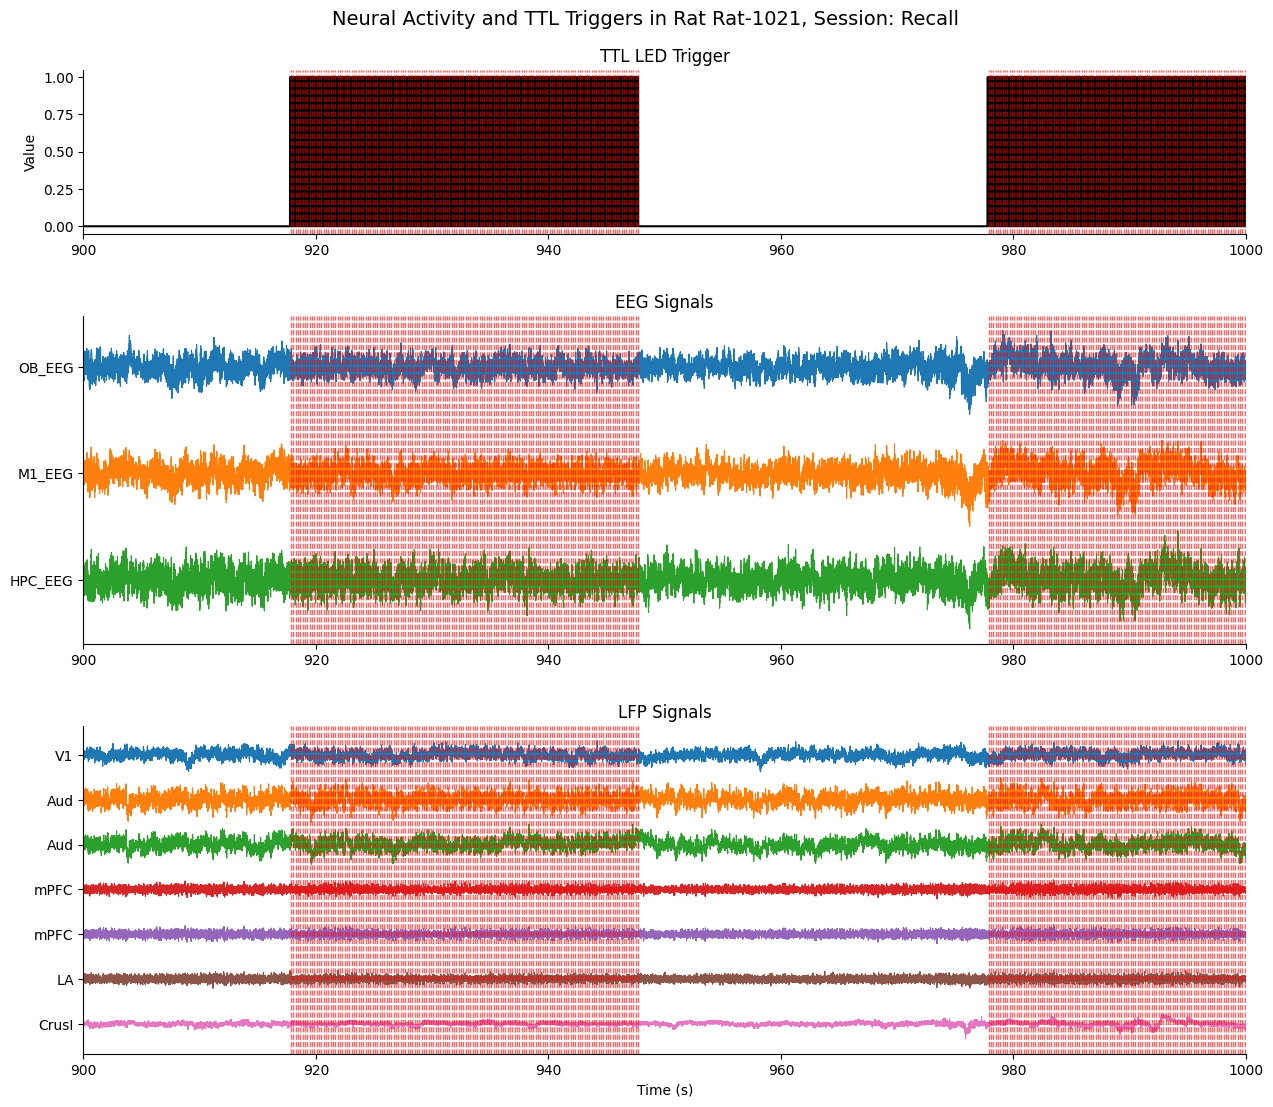

In [45]:
import numpy as np
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt

# Define a common time window to show across all signals
start_time = 900  # seconds
end_time = 1000.0  # seconds

# Create figure with GridSpec for flexible layout
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 1, height_ratios=[1, 2, 2], hspace=0.3)

# Get indices for the time window for each dataset
ttl_timestamps = LED_trigger.get_timestamps()
ttl_start_idx = (
    np.where(ttl_timestamps >= start_time)[0][0] if len(np.where(ttl_timestamps >= start_time)[0]) > 0 else 0
)
ttl_end_idx = (
    np.where(ttl_timestamps <= end_time)[0][-1]
    if len(np.where(ttl_timestamps <= end_time)[0]) > 0
    else len(ttl_timestamps) - 1
)

eeg_timestamps = eeg_series.get_timestamps()
eeg_start_idx = (
    np.where(eeg_timestamps >= start_time)[0][0] if len(np.where(eeg_timestamps >= start_time)[0]) > 0 else 0
)
eeg_end_idx = (
    np.where(eeg_timestamps <= end_time)[0][-1]
    if len(np.where(eeg_timestamps <= end_time)[0]) > 0
    else len(eeg_timestamps) - 1
)

lfp_timestamps = lfp_series.get_timestamps()
lfp_start_idx = (
    np.where(lfp_timestamps >= start_time)[0][0] if len(np.where(lfp_timestamps >= start_time)[0]) > 0 else 0
)
lfp_end_idx = (
    np.where(lfp_timestamps <= end_time)[0][-1]
    if len(np.where(lfp_timestamps <= end_time)[0]) > 0
    else len(lfp_timestamps) - 1
)

# 1. TTL Trigger Plot
ax1 = fig.add_subplot(gs[0])
ttl_data = np.array(LED_trigger.data[ttl_start_idx:ttl_end_idx])
ttl_times = ttl_timestamps[ttl_start_idx:ttl_end_idx]
ax1.plot(ttl_times, ttl_data, "k-", linewidth=1.5)
ax1.set_title("TTL LED Trigger", fontsize=12)
ax1.set_ylabel("Value")
ax1.set_xlim(start_time, end_time)
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

# 2. EEG Signals Plot
ax2 = fig.add_subplot(gs[1])
eeg_data = np.array(eeg_series.data[eeg_start_idx:eeg_end_idx])
eeg_times = eeg_timestamps[eeg_start_idx:eeg_end_idx]

# Calculate offset for stacking EEG channels
eeg_offset = np.max(np.abs(eeg_data)) * 2
eeg_y_positions = []

# Plot EEG signals
for i in range(eeg_data.shape[1]):
    y_offset = -i * eeg_offset
    ax2.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.3, linewidth=0.5)
    ax2.plot(eeg_times, eeg_data[:, i] + y_offset, linewidth=0.8)
    eeg_y_positions.append(y_offset)

# Add EEG labels and styling
ax2.set_yticks(eeg_y_positions)
eeg_labels = eeg_series.electrodes.to_dataframe()["group_name"]
eeg_labels = eeg_labels.str.replace("_electrode_group", "")
ax2.set_yticklabels(eeg_labels, fontsize=10)
ax2.set_title("EEG Signals", fontsize=12)
ax2.set_xlim(start_time, end_time)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# 3. LFP Signals Plot
ax3 = fig.add_subplot(gs[2])
lfp_data = np.array(lfp_series.data[lfp_start_idx:lfp_end_idx])
lfp_times = lfp_timestamps[lfp_start_idx:lfp_end_idx]

# Calculate offset for stacking LFP channels
lfp_offset = float(np.max(np.abs(lfp_data)) * 2)
lfp_y_positions = []

# Plot LFP signals
for i in range(lfp_data.shape[1]):
    y_offset = -i * lfp_offset
    ax3.axhline(y=y_offset, color="gray", linestyle="-", alpha=0.3, linewidth=0.5)
    ax3.plot(lfp_times, lfp_data[:, i] + y_offset, linewidth=0.8)
    lfp_y_positions.append(y_offset)

# Add LFP labels and styling
ax3.set_yticks(lfp_y_positions)
lfp_labels = lfp_series.electrodes.to_dataframe()["group_name"]
lfp_labels = lfp_labels.str.replace("_LFP_electrode_group", "")
ax3.set_yticklabels(lfp_labels, fontsize=10)
ax3.set_title("LFP Signals", fontsize=12)
ax3.set_xlabel("Time (s)", fontsize=10)
ax3.set_xlim(start_time, end_time)
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

# Add vertical lines at TTL high-to-low transitions to see stimulus alignment
high_indices = np.where(np.diff(ttl_data) < 0)[0]
for idx in high_indices:
    transition_time = ttl_times[idx]
    ax1.axvline(x=transition_time, color="r", linestyle="--", alpha=0.6, linewidth=1)
    ax2.axvline(x=transition_time, color="r", linestyle="--", alpha=0.6, linewidth=1)
    ax3.axvline(x=transition_time, color="r", linestyle="--", alpha=0.6, linewidth=1)

plt.suptitle(f"Neural Activity and TTL Triggers in Rat {subject_id}, Session: {session_id}", fontsize=14)
# plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()